In [32]:
import pandas as pd
import plotly.express as px

# Charger le fichier Excel
file_path = 'last.xlsx'
df = pd.read_excel(file_path)
nombre_total_donneurs = df.shape[0]

# Supprimer les lignes avec des dates manquantes
a = df['Date de remplissage de la fiche'].dropna()

# Convertir en datetime avec gestion des erreurs
dates = pd.to_datetime(a, format="%m/%d/%Y %H:%M", errors='coerce').dropna()

# Supposons que la colonne 'ÉLIGIBILITÉ_AU_DON.' contient les statuts
df['Date'] = pd.to_datetime(df['Date de remplissage de la fiche'], format="%m/%d/%Y %H:%M", errors='coerce')

# Filtrer les données pour les différentes catégories
df_eligible = df[df['ÉLIGIBILITÉ_AU_DON.'] == 'Eligible'].dropna(subset=['Date'])
df_temp_non_eligible = df[df['ÉLIGIBILITÉ_AU_DON.'] == 'Temporairement Non-eligible'].dropna(subset=['Date'])
df_def_non_eligible = df[df['ÉLIGIBILITÉ_AU_DON.'] == 'Définitivement non-eligible'].dropna(subset=['Date'])

# Compter les occurrences par date pour chaque catégorie
counts_total = dates.value_counts().sort_index()
counts_eligible = df_eligible['Date'].value_counts().sort_index()
counts_temp_non_eligible = df_temp_non_eligible['Date'].value_counts().sort_index()
counts_def_non_eligible = df_def_non_eligible['Date'].value_counts().sort_index()

# Créer un DataFrame combiné pour les quatre courbes
combined_df = pd.DataFrame({
    'Dates': counts_total.index,
    'Total': counts_total.values,
    'Éligibles': counts_eligible.reindex(counts_total.index, fill_value=0).values,
    'Temporairement non éligibles': counts_temp_non_eligible.reindex(counts_total.index, fill_value=0).values,
    'Définitivement non éligibles': counts_def_non_eligible.reindex(counts_total.index, fill_value=0).values
})

# Créer une figure avec plusieurs courbes
fig = px.line(combined_df, x='Dates', y=['Total', 'Éligibles', 'Temporairement non éligibles', 'Définitivement non éligibles'], 
              labels={'value': 'Nombre d\'occurrences', 'variable': 'Catégorie'},
              line_shape='spline')

# Personnaliser les couleurs et styles des courbes
fig.update_traces(
    selector=dict(name='Total'),
    line_color='#f83e8c', line_width=3, 
    fill='tozeroy', fillcolor='rgba(232, 62, 140, 0.2)'  # Rose vif
)
fig.update_traces(
    selector=dict(name='Éligibles'),
    line_color='#00cc96', line_width=3,  # Vert pour les éligibles
    fill='tozeroy', fillcolor='rgba(0, 204, 150, 0.2)'
)
fig.update_traces(
    selector=dict(name='Temporairement non éligibles'),
    line_color='#ff5733', line_width=3,  # Orange pour les temporairement non éligibles
    fill='tozeroy', fillcolor='rgba(255, 87, 51, 0.2)'
)
fig.update_traces(
    selector=dict(name='Définitivement non éligibles'),
    line_color='#8b0000', line_width=3,  # Rouge foncé pour les définitivement non éligibles
    fill='tozeroy', fillcolor='rgba(139, 0, 0, 0.2)'
)

# Personnaliser le layout avec un rangeslider
fig.update_layout(
    xaxis_title='Années',
    yaxis_title='Nombre d\'occurrences',
    xaxis=dict(
        rangeslider=dict(
            visible=True,
            thickness=0.05,  # Épaisseur réduite pour ressembler à une droite
            bgcolor='rgba(0,0,0,0.1)',  # Fond légèrement grisé
        ),
        rangeslider_bordercolor='black', rangeslider_borderwidth=2,
    ),
    legend_title_text='Catégorie'
)

# Afficher le graphique
fig.show()

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime


# Convertir la colonne 'Date de remplissage de la fiche' en datetime
df['Date de remplissage de la fiche'] = pd.to_datetime(df['Date de remplissage de la fiche'], errors='coerce')

# Filtrer les lignes où la date est valide
df = df.dropna(subset=['Date de remplissage de la fiche'])

# Compter le nombre de dons par jour
dons_par_jour = df.groupby(df['Date de remplissage de la fiche'].dt.date).size().reset_index(name='Nombre de dons')

# Générer une plage complète de dates pour inclure les jours sans dons
date_min = dons_par_jour['Date de remplissage de la fiche'].min()
date_max = dons_par_jour['Date de remplissage de la fiche'].max()
all_dates = pd.date_range(start=date_min, end=date_max, freq='D')
all_dates_df = pd.DataFrame({'Date': all_dates})
all_dates_df['Date'] = all_dates_df['Date'].dt.date

# Fusionner avec les données de dons pour inclure les jours à 0 dons
dons_par_jour = all_dates_df.merge(dons_par_jour, left_on='Date', right_on='Date de remplissage de la fiche', how='left')
dons_par_jour['Nombre de dons'] = dons_par_jour['Nombre de dons'].fillna(0)

# Ajouter les colonnes nécessaires pour le heatmap
dons_par_jour['Jour de la semaine'] = pd.to_datetime(dons_par_jour['Date']).dt.dayofweek
dons_par_jour['Semaine'] = pd.to_datetime(dons_par_jour['Date']).dt.isocalendar().week
dons_par_jour['Année'] = pd.to_datetime(dons_par_jour['Date']).dt.year

# Définir les jours de la semaine (0 = Lundi, 6 = Dimanche)
jours_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']

# Lister les années uniques
annees_uniques = sorted(dons_par_jour['Année'].unique())

# Palette de couleurs élégante : gris clair -> orange -> rouge profond
custom_colorscale = [
    [0.0, 'rgb(240, 240, 240)'],  # Gris très clair
    [0.3, 'rgb(255, 204, 153)'],  # Orange doux
    [0.6, 'rgb(255, 102, 102)'],  # Rouge corail
    [1.0, 'rgb(153, 0, 0)']       # Rouge profond
]

# Préparer les données pour chaque année
traces = []
for annee in annees_uniques:
    df_annee = dons_par_jour[dons_par_jour['Année'] == annee]
    semaines_uniques = sorted(df_annee['Semaine'].unique())
    
    # Créer une matrice pour le heatmap
    z_values = []
    for jour in range(7):
        row = []
        for semaine in semaines_uniques:
            data = df_annee[(df_annee['Jour de la semaine'] == jour) & (df_annee['Semaine'] == semaine)]
            row.append(data['Nombre de dons'].values[0] if not data.empty else 0)
        z_values.append(row)
    
    # Ajouter une trace pour chaque année avec visibilité initiale
    traces.append(
        go.Heatmap(
            z=z_values,
            x=semaines_uniques,
            y=jours_semaine,
            colorscale=custom_colorscale,
            showscale=True,
            colorbar=dict(
                title='Nombre de dons',
                titleside='top',
                tickfont=dict(size=12, color='black'),
                thickness=20,
                outlinecolor='black',
                outlinewidth=1
            ),
            hoverinfo='x+y+z',
            zmin=0,
            hovertemplate='Semaine: %{x}<br>Jour: %{y}<br>Dons: %{z}<extra></extra>',
            visible=(annee == annees_uniques[0])  # Seule la première année visible au départ
        )
    )

# Créer la figure avec toutes les traces
fig = go.Figure(data=traces)

# Ajouter le menu déroulant pour les années
updatemenus = [
    dict(
        buttons=[
            dict(
                args=[{
                    'visible': [annee == a for a in annees_uniques],
                    'title': f'Heatmap des dons - Année {annee}'
                }],
                label=str(annee),
                method='update'
            ) for annee in annees_uniques
        ],
        direction='down',
        showactive=True,
        x=0.1,
        xanchor='left',
        y=1.15,
        yanchor='top',
        bgcolor='rgba(255, 255, 255, 0.9)',
        bordercolor='gray',
        font=dict(size=12, color='black')
    )
]

# Personnaliser le layout pour un look moderne
fig.update_layout(
    title=dict(
        text=f'Heatmap des dons - Année {annees_uniques[0]}',
        font=dict(size=20, color='black', family='Arial'),
        x=0.5,
        xanchor='center'
    ),
    xaxis_title='Semaine de l\'année',
    yaxis_title='Jour de la semaine',
    xaxis=dict(
        titlefont=dict(size=14, color='black'),
        tickfont=dict(size=12, color='black'),
        gridcolor='rgba(200, 200, 200, 0.5)',
        zeroline=False
    ),
    yaxis=dict(
        titlefont=dict(size=14, color='black'),
        tickfont=dict(size=12, color='black'),
        tickmode='array',
        tickvals=list(range(7)),
        ticktext=jours_semaine,
        autorange='reversed'  # Lundi en haut
    ),
    updatemenus=updatemenus,
    plot_bgcolor='white',
    paper_bgcolor='white',
    margin=dict(l=80, r=40, t=100, b=40),
    showlegend=False,
    annotations=[
        dict(
            text="Source: vos données",
            xref="paper", yref="paper",
            x=1, y=-0.1,
            showarrow=False,
            font=dict(size=10, color='gray')
        )
    ]
)

# Ajouter des bordures légères aux cellules du heatmap
fig.update_traces(
    zmin=0,
    connectgaps=False,
    xgap=1,  # Espacement horizontal entre les cellules
    ygap=1   # Espacement vertical entre les cellules
)

# Afficher le graphique
fig.show()


Fidelisation 

In [2]:
import pandas as pd
import plotly.graph_objects as go

# Charger vos données
df = pd.read_excel('last.xlsx')  # Remplacez par le chemin de votre fichier

# Étape 1 : Appliquer les filtres

# Filtrer pour ne garder que les donneurs ayant répondu "Oui" à "A-t-il (elle) déjà donné le sang"
df = df[df['A-t-il (elle) déjà donné le sang'] == 'Oui']

# Étape 2 : Créer les flux entre chaque paire de catégories consécutives
# On va créer des paires : (A-t-il (elle) déjà donné le sang → ÉLIGIBILITÉ_AU_DON.), (ÉLIGIBILITÉ_AU_DON. → Classe_Age), etc.

# Flux 1 : A-t-il (elle) déjà donné le sang → ÉLIGIBILITÉ_AU_DON.
flux1 = df.groupby(['A-t-il (elle) déjà donné le sang', 'ÉLIGIBILITÉ_AU_DON.']).size().reset_index(name='Nombre')

# Flux 2 : ÉLIGIBILITÉ_AU_DON. → Classe_Age
flux2 = df.groupby(['ÉLIGIBILITÉ_AU_DON.', 'Classe_Age']).size().reset_index(name='Nombre')

# Flux 3 : Classe_Age → Genre_
flux3 = df.groupby(['Classe_Age', 'Genre_']).size().reset_index(name='Nombre')

# Flux 4 : Genre_ → Niveau_d_etude
flux4 = df.groupby(['Genre_', "Niveau_d'etude"]).size().reset_index(name='Nombre')

# Flux 5 : Niveau_d_etude → Religion_Catégorie
flux5 = df.groupby(["Niveau_d'etude", 'Religion_Catégorie']).size().reset_index(name='Nombre')

# Flux 6 : Religion_Catégorie → Situation_Matrimoniale_(SM)
flux6 = df.groupby(['Religion_Catégorie', 'Situation_Matrimoniale_(SM)']).size().reset_index(name='Nombre')

# Flux 7 : Situation_Matrimoniale_(SM) → categories
flux7 = df.groupby(['Situation_Matrimoniale_(SM)', 'categories']).size().reset_index(name='Nombre')

# Étape 3 : Créer la liste des nœuds (toutes les catégories uniques)
donne_sang = df['A-t-il (elle) déjà donné le sang'].unique().tolist()  # Contient uniquement "Oui" après le filtre
eligibilites = df['ÉLIGIBILITÉ_AU_DON.'].unique().tolist()
classes_age = df['Classe_Age'].unique().tolist()
genres = df['Genre_'].unique().tolist()
niveaux_etude = df["Niveau_d'etude"].unique().tolist()
religions = df['Religion_Catégorie'].unique().tolist()
situations_matrimoniales = df['Situation_Matrimoniale_(SM)'].unique().tolist()
categories = df['categories'].unique().tolist()

# Liste complète des nœuds
nodes = (donne_sang + eligibilites + classes_age + genres + niveaux_etude +
         religions + situations_matrimoniales + categories)

# Étape 4 : Créer un dictionnaire pour mapper les nœuds à des indices
node_dict = {node: idx for idx, node in enumerate(nodes)}

# Étape 5 : Créer les liens (source, target, value) pour chaque flux
# Liens pour Flux 1 : A-t-il (elle) déjà donné le sang → ÉLIGIBILITÉ_AU_DON.
source1 = flux1['A-t-il (elle) déjà donné le sang'].map(node_dict).tolist()
target1 = flux1['ÉLIGIBILITÉ_AU_DON.'].map(node_dict).tolist()
value1 = flux1['Nombre'].tolist()

# Liens pour Flux 2 : ÉLIGIBILITÉ_AU_DON. → Classe_Age
source2 = flux2['ÉLIGIBILITÉ_AU_DON.'].map(node_dict).tolist()
target2 = flux2['Classe_Age'].map(node_dict).tolist()
value2 = flux2['Nombre'].tolist()

# Liens pour Flux 3 : Classe_Age → Genre_
source3 = flux3['Classe_Age'].map(node_dict).tolist()
target3 = flux3['Genre_'].map(node_dict).tolist()
value3 = flux3['Nombre'].tolist()

# Liens pour Flux 4 : Genre_ → Niveau_d_etude
source4 = flux4['Genre_'].map(node_dict).tolist()
target4 = flux4["Niveau_d'etude"].map(node_dict).tolist()
value4 = flux4['Nombre'].tolist()

# Liens pour Flux 5 : Niveau_d_etude → Religion_Catégorie
source5 = flux5["Niveau_d'etude"].map(node_dict).tolist()
target5 = flux5['Religion_Catégorie'].map(node_dict).tolist()
value5 = flux5['Nombre'].tolist()

# Liens pour Flux 6 : Religion_Catégorie → Situation_Matrimoniale_(SM)
source6 = flux6['Religion_Catégorie'].map(node_dict).tolist()
target6 = flux6['Situation_Matrimoniale_(SM)'].map(node_dict).tolist()
value6 = flux6['Nombre'].tolist()

# Liens pour Flux 7 : Situation_Matrimoniale_(SM) → categories
source7 = flux7['Situation_Matrimoniale_(SM)'].map(node_dict).tolist()
target7 = flux7['categories'].map(node_dict).tolist()
value7 = flux7['Nombre'].tolist()

# Combiner tous les liens
source = source1 + source2 + source3 + source4 + source5 + source6 + source7
target = target1 + target2 + target3 + target4 + target5 + target6 + target7
value = value1 + value2 + value3 + value4 + value5 + value6 + value7

# Étape 6 : Définir les couleurs pour les nœuds
# On attribue des couleurs différentes pour chaque groupe de nœuds
num_donne_sang = len(donne_sang)
num_eligibilites = len(eligibilites)
num_classes_age = len(classes_age)
num_genres = len(genres)
num_niveaux_etude = len(niveaux_etude)
num_religions = len(religions)
num_situations_matrimoniales = len(situations_matrimoniales)
num_categories = len(categories)

# Couleurs pour chaque groupe
colors_donne_sang = ['#ff00ff'] * num_donne_sang  # Magenta pour A-t-il (elle) déjà donné le sang
colors_eligibilites = ['#00cc96'] * num_eligibilites  # Vert pour ÉLIGIBILITÉ_AU_DON.
colors_classes_age = ['#f83e8c'] * num_classes_age  # Rose pour Classe_Age
colors_genres = ['#8b008b'] * num_genres  # Violet foncé pour Genre_
colors_niveaux_etude = ['#1e90ff'] * num_niveaux_etude  # Bleu pour Niveau_d_etude
colors_religions = ['#ffd700'] * num_religions  # Jaune pour Religion_Catégorie
colors_situations_matrimoniales = ['#ff4500'] * num_situations_matrimoniales  # Orange pour Situation_Matrimoniale_(SM)
colors_categories = ['#00b7eb'] * num_categories  # Cyan pour categories

# Combiner les couleurs
node_colors = (colors_donne_sang + colors_eligibilites + colors_classes_age + colors_genres +
               colors_niveaux_etude + colors_religions + colors_situations_matrimoniales + colors_categories)

# Étape 7 : Créer le diagramme de Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color='rgba(200, 200, 200, 0.5)'  # Couleur des liens
    )
)])

# Étape 8 : Personnaliser le layout
fig.update_layout(
    title_text="Flux des donneurs (A-t-il donné = Oui) : A-t-il donné → Éligibilité → Classe d'âge → Genre → Niveau d'étude → Religion → Situation matrimoniale → Catégorie",
    font=dict(size=12, color='black'),
    paper_bgcolor='white',
    plot_bgcolor='white',
    width=1400,  # Ajuster la largeur pour une meilleure lisibilité
    height=1000  # Ajuster la hauteur
)

# Étape 9 : Afficher le graphique
fig.show()


Nombre total de donneurs éligibles : 1580
Nombre de donneurs éligibles récurrents : 713
Pourcentage de donneurs éligibles récurrents : 45.13%

Statistiques sur l'intervalle entre les dons (en jours) :
count      685.000000
mean      1134.224818
std       1411.323360
min       -608.000000
25%        273.000000
50%        652.000000
75%       1461.000000
max      10561.000000
Name: Intervalle_dernier_don, dtype: float64


C:\Users\USER\AppData\Local\Temp\ipykernel_24800\1679581522.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\AppData\Local\Temp\ipykernel_24800\1679581522.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\AppData\Local\Temp\ipykernel_24800\1679581522.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

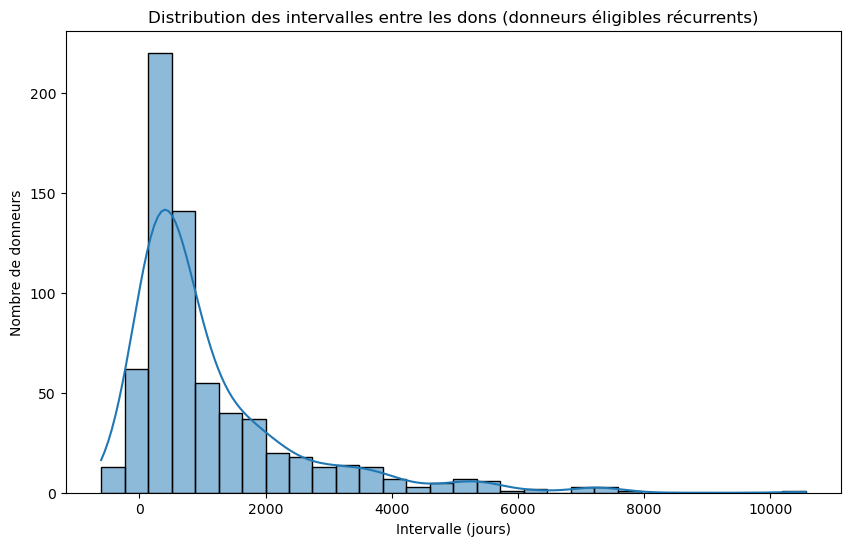

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
df = pd.read_excel('last.xlsx')

# Étape 1.1 : Filtrer les donneurs éligibles
df_eligible = df[df['ÉLIGIBILITÉ_AU_DON.'] == 'Eligible']

# Étape 1.2 : Identifier les donneurs éligibles qui ont déjà donné (donneurs récurrents)
df_eligible_recurrent = df_eligible[df_eligible['A-t-il (elle) déjà donné le sang'] == 'Oui']

# Étape 1.3 : Calculer le pourcentage de donneurs récurrents parmi les éligibles
total_eligible = len(df_eligible)
total_recurrent = len(df_eligible_recurrent)
percentage_recurrent = (total_recurrent / total_eligible) * 100

print(f"Nombre total de donneurs éligibles : {total_eligible}")
print(f"Nombre de donneurs éligibles récurrents : {total_recurrent}")
print(f"Pourcentage de donneurs éligibles récurrents : {percentage_recurrent:.2f}%")

# Étape 1.4 : Analyser la fréquence des dons (intervalle entre le dernier don et la date de remplissage)
df_eligible_recurrent['Date de remplissage de la fiche'] = pd.to_datetime(df_eligible_recurrent['Date de remplissage de la fiche'], errors='coerce')
df_eligible_recurrent['Si oui preciser la date du dernier don'] = pd.to_datetime(df_eligible_recurrent['Si oui preciser la date du dernier don'], errors='coerce')

# Calculer l'intervalle en jours
df_eligible_recurrent['Intervalle_dernier_don'] = (df_eligible_recurrent['Date de remplissage de la fiche'] - df_eligible_recurrent['Si oui preciser la date du dernier don']).dt.days

# Statistiques sur les intervalles
interval_stats = df_eligible_recurrent['Intervalle_dernier_don'].describe()
print("\nStatistiques sur l'intervalle entre les dons (en jours) :")
print(interval_stats)

# Visualisation de la distribution des intervalles
plt.figure(figsize=(10, 6))
sns.histplot(df_eligible_recurrent['Intervalle_dernier_don'].dropna(), bins=30, kde=True)
plt.title("Distribution des intervalles entre les dons (donneurs éligibles récurrents)")
plt.xlabel("Intervalle (jours)")
plt.ylabel("Nombre de donneurs")
plt.show()

In [43]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Charger les données
df = pd.read_excel('last.xlsx')

# Étape 1 : Filtrer les donneurs éligibles
df_eligible = df[df['ÉLIGIBILITÉ_AU_DON.'] == 'Eligible']

# Identifier les donneurs récurrents et non récurrents
df_eligible_recurrent = df_eligible[df_eligible['A-t-il (elle) déjà donné le sang'] == 'Oui']
df_eligible_non_recurrent = df_eligible[df_eligible['A-t-il (elle) déjà donné le sang'] == 'Non']

# Liste des colonnes démographiques à analyser
demographic_columns = ['Classe_Age', 'Genre_', "Niveau_d'etude", 'Religion_Catégorie', 
                       'Situation_Matrimoniale_(SM)', 'categories', 'Arrondissement_de_résidence_']

# Fonction pour générer un graphique Plotly avec les top 4 catégories et orientation personnalisée
def plot_top4_demographic(data_recurrent, data_non_recurrent, column, title_prefix, comparison=False, orientation='v'):
    """
    Génère un graphique Plotly avec les top 4 catégories pour une variable démographique.
    
    Parameters:
    - data_recurrent: DataFrame des donneurs récurrents
    - data_non_recurrent: DataFrame des donneurs non récurrents (pour comparaison)
    - column: Colonne démographique à analyser
    - title_prefix: Préfixe du titre du graphique
    - comparison: Booléen pour indiquer si on compare récurrents et non récurrents
    - orientation: 'v' pour vertical (par défaut), 'h' pour horizontal
    """
    # Compter les occurrences pour les donneurs récurrents et non récurrents
    if comparison:
        # Pour les graphiques de comparaison (récurrents vs non récurrents)
        count_recurrent = data_recurrent[column].value_counts()
        count_non_recurrent = data_non_recurrent[column].value_counts()
        
        # Fusionner les deux séries pour obtenir toutes les catégories
        all_categories = pd.concat([count_recurrent, count_non_recurrent], axis=1, sort=False)
        all_categories.columns = ['Récurrents', 'Non Récurrents']
        all_categories.fillna(0, inplace=True)
        
        # Calculer le total pour trier
        all_categories['Total'] = all_categories['Récurrents'] + all_categories['Non Récurrents']
        top4_categories = all_categories.sort_values('Total', ascending=False).head(4).index
        
        # Filtrer les données pour ne garder que les top 4 catégories
        count_recurrent = count_recurrent[count_recurrent.index.isin(top4_categories)]
        count_non_recurrent = count_non_recurrent[count_non_recurrent.index.isin(top4_categories)]
        
        # Créer le graphique de comparaison
        fig = go.Figure()
        
        if orientation == 'v':
            # Orientation verticale
            fig.add_trace(go.Bar(
                x=count_recurrent.index,
                y=count_recurrent.values,
                name='Récurrents (Oui)',
                marker_color='#00cc96',  # Vert
                text=count_recurrent.values,
                textposition='auto',
                hovertemplate='<b>%{x}</b><br>Nombre: %{y}<br>Catégorie: Récurrents<extra></extra>'
            ))
            
            fig.add_trace(go.Bar(
                x=count_non_recurrent.index,
                y=count_non_recurrent.values,
                name='Non Récurrents (Non)',
                marker_color='#ff5733',  # Orange
                text=count_non_recurrent.values,
                textposition='auto',
                hovertemplate='<b>%{x}</b><br>Nombre: %{y}<br>Catégorie: Non Récurrents<extra></extra>'
            ))
            
            xaxis_title = column
            yaxis_title = 'Nombre de donneurs'
            xaxis_config = dict(tickangle=45, title_standoff=25)
            yaxis_config = dict(gridcolor='rgba(0,0,0,0.1)', title_standoff=25)
            
        else:
            # Orientation horizontale
            fig.add_trace(go.Bar(
                y=count_recurrent.index,
                x=count_recurrent.values,
                name='Récurrents (Oui)',
                marker_color='#00cc96',  # Vert
                text=count_recurrent.values,
                textposition='auto',
                hovertemplate='<b>%{y}</b><br>Nombre: %{x}<br>Catégorie: Récurrents<extra></extra>',
                orientation='h'
            ))
            
            fig.add_trace(go.Bar(
                y=count_non_recurrent.index,
                x=count_non_recurrent.values,
                name='Non Récurrents (Non)',
                marker_color='#ff5733',  # Orange
                text=count_non_recurrent.values,
                textposition='auto',
                hovertemplate='<b>%{y}</b><br>Nombre: %{x}<br>Catégorie: Non Récurrents<extra></extra>',
                orientation='h'
            ))
            
            xaxis_title = 'Nombre de donneurs'
            yaxis_title = column
            xaxis_config = dict(gridcolor='rgba(0,0,0,0.1)', title_standoff=25)
            yaxis_config = dict(title_standoff=25)
            
    else:
        # Pour les graphiques de distribution (donneurs récurrents uniquement)
        count_recurrent = data_recurrent[column].value_counts()
        top4_categories = count_recurrent.head(4).index
        count_recurrent = count_recurrent[count_recurrent.index.isin(top4_categories)]
        
        # Créer le graphique de distribution
        fig = go.Figure()
        
        if orientation == 'v':
            # Orientation verticale
            fig.add_trace(go.Bar(
                x=count_recurrent.index,
                y=count_recurrent.values,
                name='Récurrents',
                marker_color='#00cc96',  # Vert
                text=count_recurrent.values,
                textposition='auto',
                hovertemplate='<b>%{x}</b><br>Nombre: %{y}<br>Catégorie: Récurrents<extra></extra>'
            ))
            
            xaxis_title = column
            yaxis_title = 'Nombre de donneurs'
            xaxis_config = dict(tickangle=45, title_standoff=25)
            yaxis_config = dict(gridcolor='rgba(0,0,0,0.1)', title_standoff=25)
            
        else:
            # Orientation horizontale
            fig.add_trace(go.Bar(
                y=count_recurrent.index,
                x=count_recurrent.values,
                name='Récurrents',
                marker_color='#00cc96',  # Vert
                text=count_recurrent.values,
                textposition='auto',
                hovertemplate='<b>%{y}</b><br>Nombre: %{x}<br>Catégorie: Récurrents<extra></extra>',
                orientation='h'
            ))
            
            xaxis_title = 'Nombre de donneurs'
            yaxis_title = column
            xaxis_config = dict(gridcolor='rgba(0,0,0,0.1)', title_standoff=25)
            yaxis_config = dict(title_standoff=25)
    
    # Personnaliser le layout
    fig.update_layout(
        title=f"{title_prefix} par {column} (Top 4)",
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        xaxis=xaxis_config,
        yaxis=yaxis_config,
        legend=dict(
            title='Statut de récurrence',
            orientation='h',
            yanchor='bottom',
            y=-0.3,
            xanchor='center',
            x=0.5
        ),
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(size=12, color='black'),
        margin=dict(l=50, r=50, t=80, b=150),
        width=800,
        height=600,
        bargap=0.2,
        barmode='group' if comparison else 'stack'
    )
    
    # Afficher le graphique
    fig.show()
    
    # Sauvegarder en HTML
    fig.write_html(f"plotly_{title_prefix.lower().replace(' ', '_')}_{column.lower()}_{orientation}.html")

# Étape 2.1 : Distribution des donneurs éligibles récurrents (Top 4 catégories)
# On peut choisir l'orientation pour chaque colonne
orientation_dict = {
    'Classe_Age': 'v',  # Vertical pour les tranches d'âge
    'Genre_': 'v',      # Vertical pour le genre
    'Niveau_d_etude': 'v',  # Vertical pour le niveau d'étude
    'Religion_Catégorie': 'h',  # Horizontal pour les religions (étiquettes longues)
    'Situation_Matrimoniale_(SM)': 'v',  # Vertical pour la situation matrimoniale
    'categories': 'h',  # Horizontal pour les catégories professionnelles (étiquettes longues)
    'Arrondissement_de_résidence_': 'h'  # Horizontal pour les arrondissements (étiquettes longues)
}

for column in demographic_columns:
    orientation = orientation_dict.get(column, 'v')  # Par défaut vertical si non spécifié
    plot_top4_demographic(
        data_recurrent=df_eligible_recurrent,
        data_non_recurrent=None,
        column=column,
        title_prefix="Distribution des donneurs éligibles récurrents",
        comparison=False,
        orientation=orientation
    )

# Étape 2.2 : Comparaison des donneurs récurrents et non récurrents (Top 4 catégories)
comparison_columns = ['Classe_Age', 'Genre_', 'categories']
comparison_orientation_dict = {
    'Classe_Age': 'v',  # Vertical pour les tranches d'âge
    'Genre_': 'v',      # Vertical pour le genre
    'categories': 'h'   # Horizontal pour les catégories professionnelles
}

for column in comparison_columns:
    orientation = comparison_orientation_dict.get(column, 'v')  # Par défaut vertical si non spécifié
    plot_top4_demographic(
        data_recurrent=df_eligible_recurrent,
        data_non_recurrent=df_eligible_non_recurrent,
        column=column,
        title_prefix="Comparaison des donneurs éligibles récurrents et non récurrents",
        comparison=True,
        orientation=orientation
    )

In [44]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Charger les données
df = pd.read_excel('last.xlsx')

# Étape 1 : Filtrer les donneurs temporairement non éligibles
df_temp_non_eligible = df[df['ÉLIGIBILITÉ_AU_DON.'] == 'Temporairement Non-eligible']

# Étape 2 : Séparer les hommes et les femmes
df_temp_men = df_temp_non_eligible[df_temp_non_eligible['Genre_'] == 'Homme']
df_temp_women = df_temp_non_eligible[df_temp_non_eligible['Genre_'] == 'Femme']

# Étape 3 : Définir une palette de couleurs pour les graphiques
color_men = '#1f77b4'  # Bleu pour les hommes
color_women = '#ff7f0e'  # Orange pour les femmes

# Fonction pour générer un graphique Plotly avec les top 4 catégories
def plot_top4_demographic(data_men, data_women, column, title_prefix, orientation='v'):
    """
    Génère un graphique Plotly comparant les hommes et les femmes temporairement non éligibles.
    
    Parameters:
    - data_men: DataFrame des hommes temporairement non éligibles
    - data_women: DataFrame des femmes temporairement non éligibles
    - column: Colonne démographique ou raison à analyser
    - title_prefix: Préfixe du titre du graphique
    - orientation: 'v' pour vertical (par défaut), 'h' pour horizontal
    """
    # Compter les occurrences pour les hommes et les femmes
    count_men = data_men[column].value_counts()
    count_women = data_women[column].value_counts()
    
    # Fusionner les deux séries pour obtenir toutes les catégories
    all_categories = pd.concat([count_men, count_women], axis=1, sort=False)
    all_categories.columns = ['Hommes', 'Femmes']
    all_categories.fillna(0, inplace=True)
    
    # Calculer le total pour trier
    all_categories['Total'] = all_categories['Hommes'] + all_categories['Femmes']
    top4_categories = all_categories.sort_values('Total', ascending=False).head(4).index
    
    # Filtrer les données pour ne garder que les top 4 catégories
    count_men = count_men[count_men.index.isin(top4_categories)]
    count_women = count_women[count_women.index.isin(top4_categories)]
    
    # Créer le graphique
    fig = go.Figure()
    
    if orientation == 'v':
        # Orientation verticale
        fig.add_trace(go.Bar(
            x=count_men.index,
            y=count_men.values,
            name='Hommes',
            marker_color=color_men,
            text=count_men.values,
            textposition='auto',
            hovertemplate='<b>%{x}</b><br>Nombre: %{y}<br>Genre: Hommes<extra></extra>'
        ))
        
        fig.add_trace(go.Bar(
            x=count_women.index,
            y=count_women.values,
            name='Femmes',
            marker_color=color_women,
            text=count_women.values,
            textposition='auto',
            hovertemplate='<b>%{x}</b><br>Nombre: %{y}<br>Genre: Femmes<extra></extra>'
        ))
        
        xaxis_title = column
        yaxis_title = 'Nombre de donneurs'
        xaxis_config = dict(tickangle=45, title_standoff=25)
        yaxis_config = dict(gridcolor='rgba(0,0,0,0.1)', title_standoff=25)
        
    else:
        # Orientation horizontale
        fig.add_trace(go.Bar(
            y=count_men.index,
            x=count_men.values,
            name='Hommes',
            marker_color=color_men,
            text=count_men.values,
            textposition='auto',
            hovertemplate='<b>%{y}</b><br>Nombre: %{x}<br>Genre: Hommes<extra></extra>',
            orientation='h'
        ))
        
        fig.add_trace(go.Bar(
            y=count_women.index,
            x=count_women.values,
            name='Femmes',
            marker_color=color_women,
            text=count_women.values,
            textposition='auto',
            hovertemplate='<b>%{y}</b><br>Nombre: %{x}<br>Genre: Femmes<extra></extra>',
            orientation='h'
        ))
        
        xaxis_title = 'Nombre de donneurs'
        yaxis_title = column
        xaxis_config = dict(gridcolor='rgba(0,0,0,0.1)', title_standoff=25)
        yaxis_config = dict(title_standoff=25)
    
    # Personnaliser le layout
    fig.update_layout(
        title=f"{title_prefix} par {column} (Top 4)",
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        xaxis=xaxis_config,
        yaxis=yaxis_config,
        legend=dict(
            title='Genre',
            orientation='h',
            yanchor='bottom',
            y=-0.3,
            xanchor='center',
            x=0.5
        ),
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(size=12, color='black'),
        margin=dict(l=50, r=50, t=80, b=150),
        width=800,
        height=600,
        bargap=0.2,
        barmode='group'
    )
    
    # Afficher le graphique
    fig.show()
    
    # Sauvegarder en HTML
    fig.write_html(f"plotly_{title_prefix.lower().replace(' ', '_')}_{column.lower()}_{orientation}.html")

# Étape 4 : Analyser les profils démographiques et les raisons d’inéligibilité
demographic_columns = ['Classe_Age', 'categories', 'Arrondissement_de_résidence_', 'Raison_indisponibilité_fusionnée']

# Dictionnaire pour l'orientation
orientation_dict = {
    'Classe_Age': 'v',  # Vertical pour les tranches d'âge
    'categories': 'h',  # Horizontal pour les catégories professionnelles (étiquettes longues)
    'Arrondissement_de_résidence_': 'h',  # Horizontal pour les arrondissements (étiquettes longues)
    'Raison_indisponibilité_fusionnée': 'h'  # Horizontal pour les raisons (étiquettes longues)
}

# Générer les graphiques pour chaque colonne
for column in demographic_columns:
    orientation = orientation_dict.get(column, 'v')  # Par défaut vertical si non spécifié
    plot_top4_demographic(
        data_men=df_temp_men,
        data_women=df_temp_women,
        column=column,
        title_prefix="Profil des donneurs temporairement non éligibles",
        orientation=orientation
    )

# Étape 5 : Résumé textuel des profils
print("\nRésumé des profils des donneurs temporairement non éligibles :")
print("\nHommes :")
print(f"Nombre total : {len(df_temp_men)}")
print("Tranches d'âge les plus fréquentes :")
print(df_temp_men['Classe_Age'].value_counts().head(4))
print("Catégories professionnelles les plus fréquentes :")
print(df_temp_men['categories'].value_counts().head(4))
print("Arrondissements les plus fréquents :")
print(df_temp_men['Arrondissement_de_résidence_'].value_counts().head(4))
print("Raisons d’inéligibilité les plus fréquentes :")
print(df_temp_men['Raison_indisponibilité_fusionnée'].value_counts().head(4))

print("\nFemmes :")
print(f"Nombre total : {len(df_temp_women)}")
print("Tranches d'âge les plus fréquentes :")
print(df_temp_women['Classe_Age'].value_counts().head(4))
print("Catégories professionnelles les plus fréquentes :")
print(df_temp_women['categories'].value_counts().head(4))
print("Arrondissements les plus fréquents :")
print(df_temp_women['Arrondissement_de_résidence_'].value_counts().head(4))
print("Raisons d’inéligibilité les plus fréquentes :")
print(df_temp_women['Raison_indisponibilité_fusionnée'].value_counts().head(4))


Résumé des profils des donneurs temporairement non éligibles :

Hommes :
Nombre total : 152
Tranches d'âge les plus fréquentes :
Classe_Age
18-25 ans    66
26-35 ans    58
36-50 ans    23
51-65 ans     4
Name: count, dtype: int64
Catégories professionnelles les plus fréquentes :
categories
Employé/ouvrier qualifié         56
Apprenti rénuméré ou non         25
Sans emploi                      23
Employé/ouvrier semi qualifié    11
Name: count, dtype: int64
Arrondissements les plus fréquents :
Arrondissement_de_résidence_
Douala 3    48
Douala 1    28
Douala 2    23
Douala 5    13
Name: count, dtype: int64
Raisons d’inéligibilité les plus fréquentes :
Raison_indisponibilité_fusionnée
Taux d’hémoglobine bas                                  91
Est sous anti-biothérapie                               25
Est sous anti-biothérapie  ; Taux d’hémoglobine bas      3
IST récente (Exclu VIH, Hbs, Hcv)                        2
Name: count, dtype: int64

Femmes :
Nombre total : 60
Tranches d'âge le